#**Машинное обучение ИБ-2024**

#**Домашнее задание 1.**
#Регрессия, KNN, LinearRegression.

В данной домашней работе мы будем строить модели для предсказания цены квартиры в России. Ниже приведено описание некоторых колонок набора данных.

date - дата публикации объявления

price - цена в рублях

level- этаж, на котором находится квартира

levels - количество этажей в квартире

rooms - количество комнат в квартире. Если значение -1, то квартира считается апартаментами.

area - площадь квартиры.

kitchen_area - площадь кухни.

geo_lat - Latitude

geo_lon - Longitude

building_type - материал застройки. 0 - Don't know. 1 - Other. 2 - Panel. 3 - Monolithic. 4 - Brick. 5 - Blocky. 6 - Wooden

#Часть 0. Начало работы

Для начала работы с данными импортируем библиотеки, которые понадобятся в данном задании.

In [36]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

Загрузим библиотеку folium для отображения данных на карте по координатам.

In [2]:
!pip install folium

Распакуем наши данные из архива.

In [ ]:
!unzip ...

Загрузим данные из csv файла в датафрейм.

In [37]:
df = pd.read_csv('input_data.csv', sep=';')
display(df.head())
display(df.tail())
rows, cols = df.shape
print(f"\nВ файле {rows} строк и {cols} столбцов")

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
0,2021-01-01,2451300,15,31,1,30.3,0.0,56.780112,60.699355,0,2,620000.0,NaN,66,1632918.0
1,2021-01-01,1450000,5,5,1,33.0,6.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN
2,2021-01-01,10700000,4,13,3,85.0,12.0,55.540060,37.725112,3,0,142701.0,242543.0,50,681306.0
3,2021-01-01,3100000,3,5,3,82.0,9.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN
4,2021-01-01,2500000,2,3,1,30.0,9.0,44.738685,37.713668,3,2,353960.0,439378.0,23,1730985.0


,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
11358145,2021-12-31,6099000,4,9,3,65.0,0.0,56.041539,92.753133,0,0,660030.0,581436.0,24,857003.0
11358146,2021-12-31,2490000,1,10,2,56.9,0.0,55.169949,61.519210,0,0,454079.0,274414.0,74,1820769.0
11358147,2021-12-31,850000,2,2,2,37.0,5.0,55.946206,43.088179,0,0,606101.0,190983.0,52,958329.0
11358148,2021-12-31,4360000,5,5,1,36.0,9.0,61.256383,73.435919,0,0,628406.0,581702.0,86,2156710.0
11358149,2021-12-31,1850000,1,5,1,33.0,7.0,55.164522,61.386448,0,0,454080.0,567218.0,74,2591215.0



В файле 11358150 строк и 15 столбцов


Отобразим на карте координаты наших построек.

In [38]:
import folium
from IPython.display import display

map_df = df.loc[:1000]

m = folium.Map(location=[55.751244, 37.618423], zoom_start=10)

# Список точек с широтой и долготой
lats = map_df['geo_lat'].loc[:1000]
longs = map_df['geo_lon'].loc[:1000]
# Добавляем точки на карту
for point in zip(lats, longs):
    folium.Marker(
        location=[point[0], point[1]]
    ).add_to(m)

display(m)

# Часть 1. Подготовим данные для обработки моделями машинного обучения.

**0.5 Балл**. География наших наблюдений в наборе данных крайне большая. Однако мы знаем, что стоимость квартир в Москве и Санкт-Петербурге намного выше, чем в среднем по России. Давайте сделаем признаки, который показывают, находится ли квартира в 20 килиметрах от центра Москвы или находится ли квартира в 20 килиметрах от центра Санкт-Петербурга.

Создайте два признака is_Moscow и is_Saint_Peterburg. Для нахождения расстояния по координатам используйте функцию haversine_distance.

In [39]:
def haversine_distance(lat1, lon1, lat2, lon2):
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0
    lat1 = (lat1) * math.pi / 180.0
    lat2 = (lat2) * math.pi / 180.0
    a = (pow(math.sin(dLat / 2), 2) + pow(math.sin(dLon / 2), 2) * math.cos(lat1) * math.cos(lat2))
    rad_earth = 6371
    c = 2 * math.asin(math.sqrt(a))
    return rad_earth * c

def which_city(df):
    moscow_lat, moscow_lon = 55.7558, 37.6176
    spb_lat, spb_lon = 59.9375, 30.3086
    df['is_Moscow'] = df.apply(
        lambda row: 1 if haversine_distance(row['geo_lat'], row['geo_lon'], moscow_lat, moscow_lon) <= 20 else 0,
        axis=1
    )
    df['is_Saint_Peterburg'] = df.apply(
        lambda row: 1 if haversine_distance(row['geo_lat'], row['geo_lon'], spb_lat, spb_lon) <= 20 else 0,
        axis=1
    )
which_city(df)

In [40]:
display(df.head())
display(df.tail())
rows, cols = df.shape
print(f"\nВ файле {rows} строк и {cols} столбцов")

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id,is_Moscow,is_Saint_Peterburg
0,2021-01-01,2451300,15,31,1,30.3,0.0,56.780112,60.699355,0,2,620000.0,NaN,66,1632918.0,0,0
1,2021-01-01,1450000,5,5,1,33.0,6.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN,0,0
2,2021-01-01,10700000,4,13,3,85.0,12.0,55.540060,37.725112,3,0,142701.0,242543.0,50,681306.0,0,0
3,2021-01-01,3100000,3,5,3,82.0,9.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN,0,0
4,2021-01-01,2500000,2,3,1,30.0,9.0,44.738685,37.713668,3,2,353960.0,439378.0,23,1730985.0,0,0


,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id,is_Moscow,is_Saint_Peterburg
11358145,2021-12-31,6099000,4,9,3,65.0,0.0,56.041539,92.753133,0,0,660030.0,581436.0,24,857003.0,0,0
11358146,2021-12-31,2490000,1,10,2,56.9,0.0,55.169949,61.519210,0,0,454079.0,274414.0,74,1820769.0,0,0
11358147,2021-12-31,850000,2,2,2,37.0,5.0,55.946206,43.088179,0,0,606101.0,190983.0,52,958329.0,0,0
11358148,2021-12-31,4360000,5,5,1,36.0,9.0,61.256383,73.435919,0,0,628406.0,581702.0,86,2156710.0,0,0
11358149,2021-12-31,1850000,1,5,1,33.0,7.0,55.164522,61.386448,0,0,454080.0,567218.0,74,2591215.0,0,0



В файле 11358150 строк и 17 столбцов


**0.5 Балла**. В нашем наборе данных есть признаки, которые мы теоретически можем использовать, например postal_code, но мы это будем делать в рамках домашней работы очень-очень долго. Поэтому предлагается удалить ненужные признаки из датафрейма.

Удалим geo_lat,	geo_lon,	object_type,	postal_code,	street_id,	id_region,	house_id.

In [41]:
features_to_delete = ['geo_lat', 'geo_lon', 'object_type', 'postal_code', 'street_id', 'id_region', 'house_id']
df.drop(columns=features_to_delete, inplace=True)

In [42]:
display(df.head())
display(df.tail())
rows, cols = df.shape
print(f"\nВ файле {rows} строк и {cols} столбцов")

,date,price,level,levels,rooms,area,kitchen_area,building_type,is_Moscow,is_Saint_Peterburg
0,2021-01-01,2451300,15,31,1,30.3,0.0,0,0,0
1,2021-01-01,1450000,5,5,1,33.0,6.0,0,0,0
2,2021-01-01,10700000,4,13,3,85.0,12.0,3,0,0
3,2021-01-01,3100000,3,5,3,82.0,9.0,0,0,0
4,2021-01-01,2500000,2,3,1,30.0,9.0,3,0,0


,date,price,level,levels,rooms,area,kitchen_area,building_type,is_Moscow,is_Saint_Peterburg
11358145,2021-12-31,6099000,4,9,3,65.0,0.0,0,0,0
11358146,2021-12-31,2490000,1,10,2,56.9,0.0,0,0,0
11358147,2021-12-31,850000,2,2,2,37.0,5.0,0,0,0
11358148,2021-12-31,4360000,5,5,1,36.0,9.0,0,0,0
11358149,2021-12-31,1850000,1,5,1,33.0,7.0,0,0,0



В файле 11358150 строк и 10 столбцов


**0.5 Балл**. Для начала Вам предлагается проанализировать Ваши оставшиеся признаки (колонки) в наборе данных. Какие колонки категориальные? Какие числовые?

Категориальные: building_type, is_Moscow, is_Saint_Peterburg

Числовые: date, price, level, levels, rooms, area, kitchen_area

Давайте закодируем категориальные признаки с помощью OneHot-Encoding. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [43]:
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['building_type', 'is_Moscow', 'is_Saint_Peterburg']

# Инициализируем OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Обучаем энкодер на категориальных колонках и преобразуем их
encoded_data = encoder.fit_transform(df[categorical_cols])

# Создаем DataFrame из закодированных данных
# Получаем имена новых колонок
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names, index=df.index)

# Удаляем исходные категориальные колонки из оригинального DataFrame
df_processed = df.drop(columns=categorical_cols)

# Объединяем DataFrame с закодированными признаками и DataFrame с числовыми признаками
df_processed = pd.concat([df_processed, encoded_df], axis=1)

display(df_processed.head())
display(df_processed.tail())
rows, cols = df_processed.shape
print(f"\nВ файле {rows} строк и {cols} столбцов")

,date,price,level,levels,rooms,area,kitchen_area,building_type_0,building_type_1,building_type_2,building_type_3,building_type_4,building_type_5,building_type_6,is_Moscow_0,is_Moscow_1,is_Saint_Peterburg_0,is_Saint_Peterburg_1
0,2021-01-01,2451300,15,31,1,30.3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,2021-01-01,1450000,5,5,1,33.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,2021-01-01,10700000,4,13,3,85.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,2021-01-01,3100000,3,5,3,82.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,2021-01-01,2500000,2,3,1,30.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


,date,price,level,levels,rooms,area,kitchen_area,building_type_0,building_type_1,building_type_2,building_type_3,building_type_4,building_type_5,building_type_6,is_Moscow_0,is_Moscow_1,is_Saint_Peterburg_0,is_Saint_Peterburg_1
11358145,2021-12-31,6099000,4,9,3,65.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
11358146,2021-12-31,2490000,1,10,2,56.9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
11358147,2021-12-31,850000,2,2,2,37.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
11358148,2021-12-31,4360000,5,5,1,36.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
11358149,2021-12-31,1850000,1,5,1,33.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0



В файле 11358150 строк и 18 столбцов


**0.5 Балл**. Поработаем с числовыми признаками:


1.   Добавьте в ваш датасет два признака: количество дней со дня первого наблюдения (разница между датами объявлений). Возможно, для предсказания цены не так важен этаж, как важно отношение этажа квартиры на количество этажей в доме, добавьте этот признак. После добавления нового признака колонку date можно удалить.
2.   Числовые признаки могут иметь разные порядки. Давайте отнормируем числовые признаки с помощью StandartScaller https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html.



In [44]:
from sklearn.preprocessing import StandardScaler

df_processed['date'] = pd.to_datetime(df_processed['date'])

# Добавляем признак "количество дней со дня первого наблюдения"
min_date = df_processed['date'].min()
df_processed['days_since_first_observation'] = (df_processed['date'] - min_date).dt.days

# Добавляем признак "отношение этажа квартиры к количеству этажей"
df_processed['level_ratio'] = df_processed['level'] / df_processed['levels'].replace(0, 1) # Заменяем 0 на 1, чтобы избежать ошибки

# Удаляем колонки 'date'
df_processed = df_processed.drop('date', axis=1)

numerical_features = ['level', 'levels', 'rooms', 'area', 'kitchen_area',
                      'days_since_first_observation', 'level_ratio']

# Создаем объект StandardScaler
scaler = StandardScaler()

# Применяем масштабирование к выбранным числовым признакам
df_processed[numerical_features] = scaler.fit_transform(df_processed[numerical_features])

# Выведем измененный DataFrame
display(df_processed.head())
display(df_processed.tail())
rows, cols = df_processed.shape
print(f"\nВ файле {rows} строк и {cols} столбцов")

,price,level,levels,rooms,area,kitchen_area,building_type_0,building_type_1,building_type_2,building_type_3,building_type_4,building_type_5,building_type_6,is_Moscow_0,is_Moscow_1,is_Saint_Peterburg_0,is_Saint_Peterburg_1,days_since_first_observation,level_ratio
0,2451300,1.622769,2.665027,-0.621470,-0.840577,0.082486,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.858355,-0.288681
1,1450000,-0.270043,-0.936859,-0.621470,-0.741051,0.267565,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.858355,1.337255
2,10700000,-0.459324,0.171414,1.106234,1.175756,0.452644,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.858355,-0.843688
3,3100000,-0.648605,-0.936859,1.106234,1.065171,0.360105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.858355,0.077155
4,2500000,-0.837886,-1.213927,-0.621470,-0.851636,0.360105,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.858355,0.287172


,price,level,levels,rooms,area,kitchen_area,building_type_0,building_type_1,building_type_2,building_type_3,building_type_4,building_type_5,building_type_6,is_Moscow_0,is_Moscow_1,is_Saint_Peterburg_0,is_Saint_Peterburg_1,days_since_first_observation,level_ratio
11358145,6099000,-0.459324,-0.382722,1.106234,0.438523,0.082486,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.752639,-0.412884
11358146,2490000,-1.027168,-0.244188,0.242382,0.139943,0.082486,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.752639,-1.497970
11358147,850000,-0.837886,-1.352461,0.242382,-0.593604,0.236719,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.752639,1.337255
11358148,4360000,-0.270043,-0.936859,-0.621470,-0.630466,0.360105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.752639,1.337255
11358149,1850000,-1.027168,-0.936859,-0.621470,-0.741051,0.298412,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.752639,-1.182945



В файле 11358150 строк и 19 столбцов


**2 Балла**. Реализуйте класс KNNRegressor, который должен делать регрессию методом k ближайших соседей.

In [48]:
class KNNRegressor:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        """
        Инициализирует модель KNNRegressor.

        Args:
            n_neighbors (int): Количество ближайших соседей для учета при прогнозировании.
            metric (str): Метрика расстояния, которая должна быть 'euclidean'.
                          В данном классе поддерживается только евклидово расстояние.
        """
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        """
        Обучает модель KNNRegressor, сохраняя тренировочные данные.
        Автоматически преобразует X_train и y_train в массивы numpy.

        Args:
            X_train: Тренировочные признаки. Будет преобразовано в np.ndarray.
            y_train: Тренировочные целевые значения. Будет преобразовано в np.ndarray.
        """
        # Преобразуем входные данные в массивы numpy
        self.X_train = np.asarray(X_train) # Указываем тип для безопасности
        self.y_train = np.asarray(y_train) # Указываем тип для безопасности

    def predict(self, X_test):
        """
        Прогнозирует целевые значения для тестовых данных.
        Автоматически преобразует X_test в массив numpy.

        Args:
            X_test: Тестовые признаки. Будет преобразовано в np.ndarray.

        Returns:
            np.ndarray: Прогнозируемые целевые значения.
        """
        # Преобразуем входные данные в массивы numpy
        X_test = np.asarray(X_test)
        predictions = []
        # Итерируемся только по тестовым точкам
        for x_test_point in X_test:
            # Проверяем метрику 
            if self.metric == 'euclidean':
                # Используем векторизованную функцию для вычисления расстояний
                distances = np.sqrt(np.sum((x_test_point - self.X_train)**2, axis=-1))
            # Создаем пары (расстояние, целевое_значение)
            distances_and_labels = list(zip(distances, self.y_train))
            # Сортируем соседей по расстоянию
            distances_and_labels.sort(key=lambda x: x[0])
            # Берем n_neighbors ближайших соседей
            k_nearest_neighbors = distances_and_labels[:self.n_neighbors]
            # Вычисляем среднее значение целевых значений ближайших соседей
            k_neighbor_values = [neighbor[1] for neighbor in k_nearest_neighbors]
            predicted_value = np.mean(k_neighbor_values)
            predictions.append(predicted_value)
        return np.array(predictions)

**3 Балла**. Реализуйте класс LinearRegression, поддерживающий обучение градиентными спусками SGD, Momentum, AdaGrad. Используйте градиент для оптимизации функции потерь MSE.

In [47]:
class LinearRegression:
    def __init__(self, learning_rate=0.01, optimization='SGD', epsilon=1e-8, decay_rate=0.9, max_iter=1000):
        """
        Инициализация модели линейной регрессии.

        Args:
            learning_rate (float): Скорость обучения.
            optimization (str): Метод оптимизации ('SGD', 'Momentum', 'AdaGrad').
            epsilon (float): Малый параметр для предотвращения деления на ноль (для AdaGrad).
            decay_rate (float): Коэффициент замедления (для Momentum).
            max_iter (int): Максимальное количество итераций обучения.
        """
        self.learning_rate = learning_rate
        self.optimization = optimization.upper() # Приводим к верхнему регистру для удобства сравнения
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.max_iter = max_iter
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        """
        Обучение модели линейной регрессии.

        Args:
            X (np.ndarray): Матрица признаков, где каждая строка — объект, а каждый столбец — признак.
            y (np.ndarray): Вектор целевых значений.
        """
        num_samples, num_features = X.shape
        # Инициализация весов и смещения
        self.weights = np.zeros(num_features)
        self.bias = 0
        # Добавляем столбец единиц к X для удобной работы со смещением
        X_b = np.c_[X, np.ones(num_samples)] # Добавляем столбец единиц
        weights_bias = np.zeros(num_features + 1) # Веса, включая bias
        # Инициализируем weights_bias нулями
        weights_bias[:-1] = self.weights
        weights_bias[-1] = self.bias
        # Переменные для хранения состояний оптимизаторов (с учетом bias)
        velocity = np.zeros(num_features + 1)
        sum_sq_grad = np.zeros(num_features + 1)
        print(f"Начато обучение с методом: {self.optimization}")

        for i in range(self.max_iter):
            y_pred = np.dot(X_b, weights_bias)
            # Вычисление ошибки и градиентов
            residuals = y_pred - y
            grad = (2 / num_samples) * np.dot(X_b.T, residuals) # grad - это [dw1, dw2, ..., dw_n, db]
            # Обновление весов в зависимости от метода оптимизации
            if self.optimization == 'SGD':
                weights_bias -= self.learning_rate * grad
            elif self.optimization == 'MOMENTUM':
                velocity = self.decay_rate * velocity + self.learning_rate * grad
                weights_bias -= velocity
            elif self.optimization == 'ADAGRAD':
                sum_sq_grad += grad**2
                weights_bias -= (self.learning_rate / (np.sqrt(sum_sq_grad) + self.epsilon)) * grad

        # После обучения извлекаем обновленные веса и смещение
        self.weights = weights_bias[:-1]
        self.bias = weights_bias[-1]
        print("Обучение завершено.")


    def predict(self, X):
        """
        Предсказание целевых значений для новых данных.

        Args:
            X (np.ndarray): Матрица признаков для предсказания.

        Returns:
            np.ndarray: Вектор предсказанных значений.
        """
        y_pred = np.dot(X, self.weights) + self.bias
        return y_pred

# Часть 2. Эксперименты с моделями машинного обучения.

**3 Балла**. Проведите эксперименты с написанными Вами методами машинного обучения. Выделите обучающую и тестовую выборки в отношении 0,8 и 0,2 соответственно. Измерьте ошибку MSE, MAE, RMSE. Заиспользуйте методы KNNRegressor и LinearRegression из библиотеки sklearn, сравните качество Ваших решений и библиотечных.


Sklearn KNNRegressor:
  MSE: 13796054282851.5273
  MAE: 1851773.2030
  RMSE: 3714304.0106

My KNNRegressor:
  MSE: 13796054282851.5273
  MAE: 1851773.2030
  RMSE: 3714304.0106
Начато обучение с методом: SGD
Обучение завершено.

MY Linear Regression (SGD):
  MSE: 2021813208390265600.0000
  MAE: 6990003.5492
  RMSE: 1421904781.7594
Начато обучение с методом: MOMENTUM
Обучение завершено.

MY Linear Regression (Momentum):
  MSE: 2021819073518291712.0000
  MAE: 7014825.2665
  RMSE: 1421906844.1773
Начато обучение с методом: ADAGRAD
Обучение завершено.

MY Linear Regression (AdaGrad):
  MSE: 2022044401691890176.0000
  MAE: 9185568.6149
  RMSE: 1421986076.4761

Sklearn Linear Regression (SGDRegressor):
  MSE: 2021822371973168640.0000
  MAE: 7021743.2786
  RMSE: 1421908004.0471

Sklearn Linear Regression:
  MSE: 2021822146247087360.0000
  MAE: 7023066.1828
  RMSE: 1421907924.6727

 Сomparison LinearRegression(SGD):
  MSE: -9163582903040.0000
  MAE: -31739.7293
  RMSE: -3222.2877

 Сomparison 

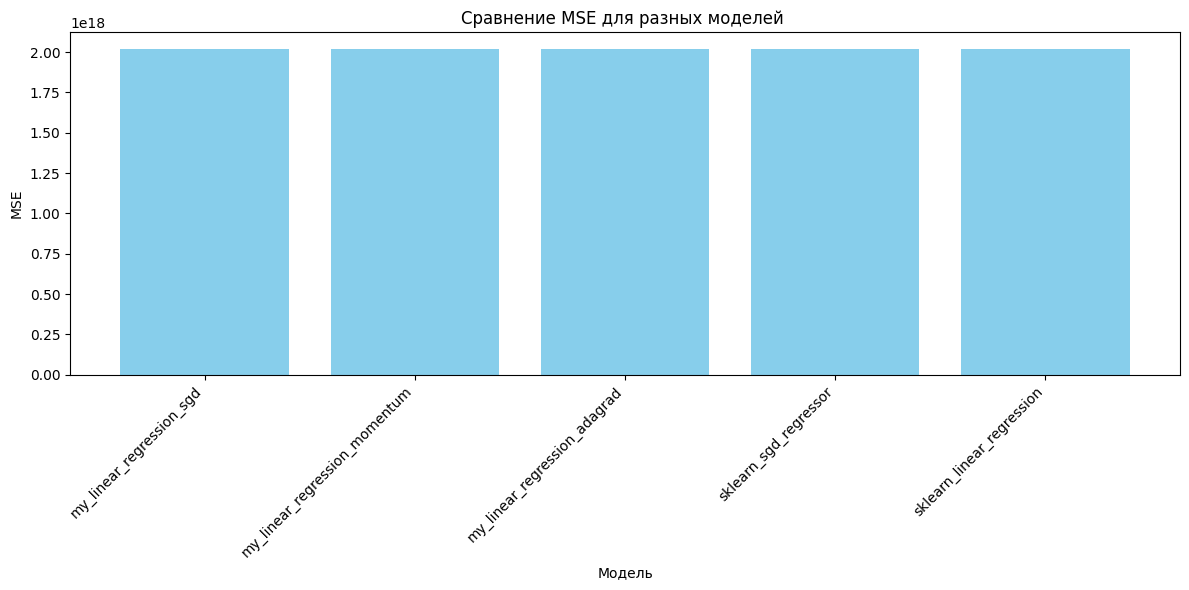

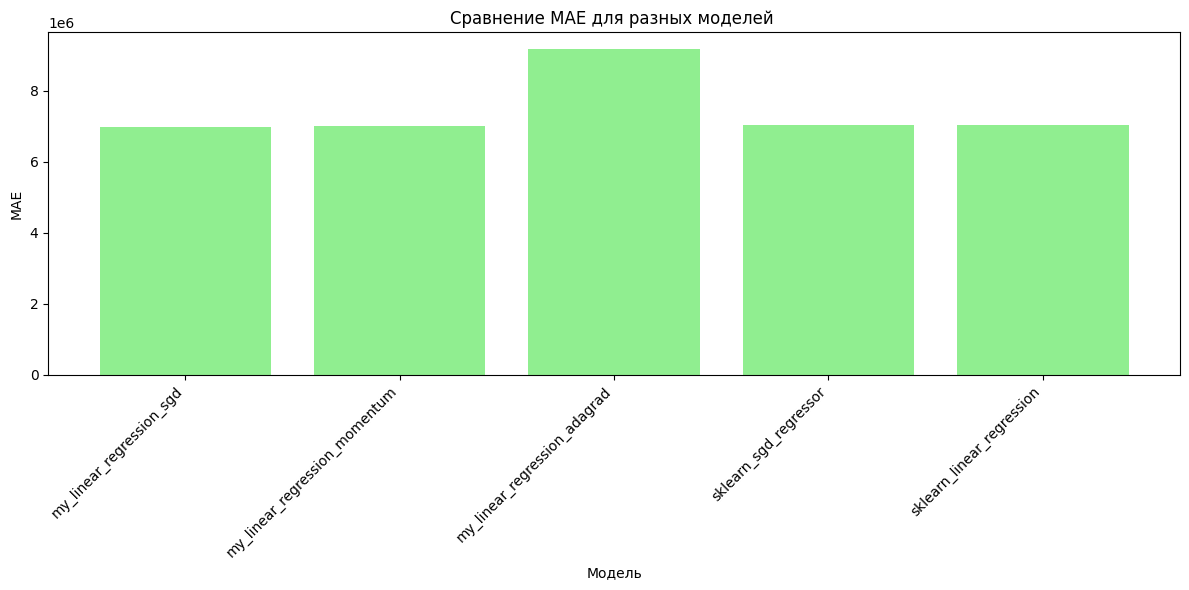

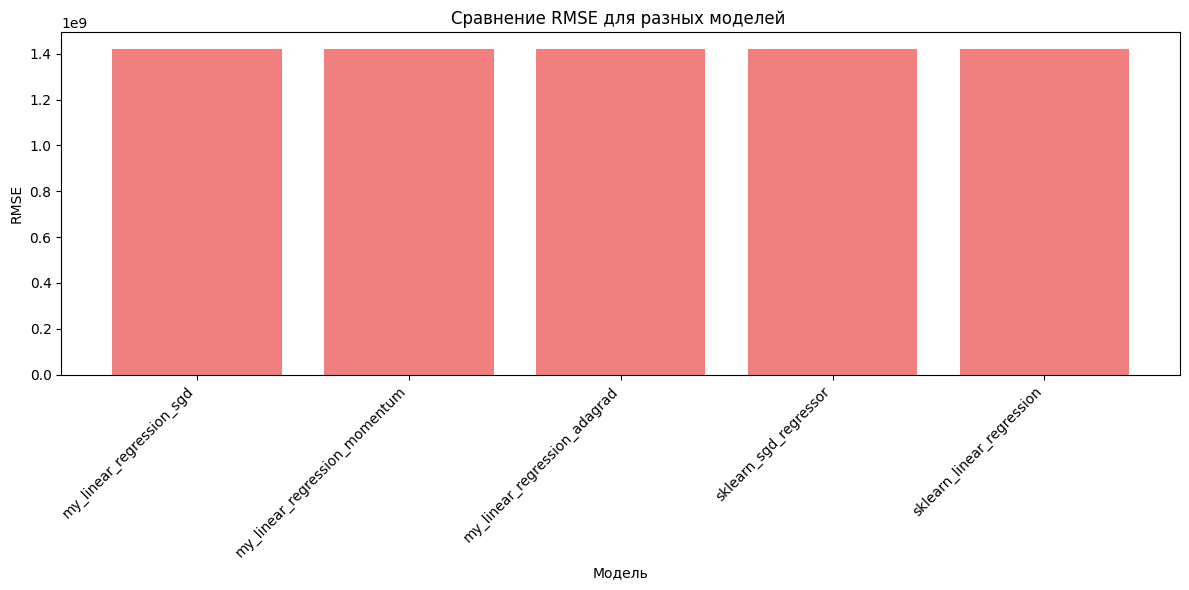

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.linear_model import SGDRegressor

X = df_processed.head(1000)[['level', 'levels', 'rooms', 'area', 'kitchen_area', 'building_type_0', 'building_type_1', 'building_type_2',
        'building_type_3', 'building_type_4', 'building_type_5', 'building_type_6', 'is_Moscow_0', 'is_Moscow_1', 'is_Saint_Peterburg_0',	
        'is_Saint_Peterburg_1',	'days_since_first_observation',	'level_ratio']]
y = df_processed.head(1000)['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

metrics_to_test = ['euclidean', 'manhattan', 'cosine']
results = {}

def evaluate_and_print_regressor(regressor_name, y_true, y_pred):
    """
    Вычисляет, выводит метрики (MSE, MAE, RMSE) для предсказаний регрессора
    и сохраняет их в словарь.

    Args:
        regressor_name (str): Название регрессора для вывода.
        y_true (array-like): Истинные значения целевой переменной.
        y_pred (array-like): Предсказанные значения целевой переменной.
        results_dict (dict): Словарь для сохранения результатов.
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"\n{regressor_name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    return mse, mae, rmse

# Sklearn KNN
sklearn_knn = KNeighborsRegressor(n_neighbors=5, metric='euclidean')
sklearn_knn.fit(X_train, y_train)
sklearn_knn_predictions = sklearn_knn.predict(X_test)
mse_sklearn_knn, mae_sklearn_knn, rmse_sklearn_knn = evaluate_and_print_regressor("Sklearn KNNRegressor", y_test, sklearn_knn_predictions)
results['sklearn_knn'] = {'mse': mse_sklearn_knn, 'mae': mae_sklearn_knn, 'rmse': rmse_sklearn_knn}
#  KNN
my_knn = KNNRegressor(n_neighbors=5, metric='euclidean')
my_knn.fit(X_train, y_train)
my_knn_predictions = my_knn.predict(X_test)
mse_my_knn, mae_my_knn, rmse_my_knn = evaluate_and_print_regressor("My KNNRegressor", y_test, my_knn_predictions)
results['knn'] = {'mse': mse_my_knn, 'mae': mae_my_knn, 'rmse': rmse_my_knn}

X = df_processed.head(1000000)[['level', 'levels', 'rooms', 'area', 'kitchen_area', 'building_type_0', 'building_type_1', 'building_type_2',
        'building_type_3', 'building_type_4', 'building_type_5', 'building_type_6', 'is_Moscow_0', 'is_Moscow_1', 'is_Saint_Peterburg_0',	
        'is_Saint_Peterburg_1',	'days_since_first_observation',	'level_ratio']]
y = df_processed.head(1000000)['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Linear Regression (SGD)
my_lr_sgd = LinearRegression(learning_rate=0.01, optimization='SGD', max_iter=1000)
my_lr_sgd.fit(X_train, y_train)
my_lr_sgd_predictions = my_lr_sgd.predict(X_test)
mse_my_lr_sgd, mae_my_lr_sgd, rmse_my_lr_sgd = evaluate_and_print_regressor("MY Linear Regression (SGD)", y_test, my_lr_sgd_predictions)
results['my_linear_regression_sgd'] = {'mse': mse_my_lr_sgd, 'mae': mae_my_lr_sgd, 'rmse': rmse_my_lr_sgd}
# Linear Regression (Momentum)
my_lr_momentum = LinearRegression(learning_rate=0.01, optimization='Momentum', decay_rate=0.9, max_iter=1000)
my_lr_momentum.fit(X_train, y_train)
my_lr_momentum_predictions = my_lr_momentum.predict(X_test)
mse_my_lr_momentum, mae_my_lr_momentum, rmse_my_lr_momentum = evaluate_and_print_regressor("MY Linear Regression (Momentum)", y_test, my_lr_momentum_predictions)
results['my_linear_regression_momentum'] = {'mse': mse_my_lr_momentum, 'mae': mae_my_lr_momentum, 'rmse': rmse_my_lr_momentum}
# Linear Regression (AdaGrad)
my_lr_adagrad = LinearRegression(learning_rate=0.01, optimization='AdaGrad', max_iter=1000)
my_lr_adagrad.fit(X_train, y_train)
my_lr_adagrad_predictions = my_lr_adagrad.predict(X_test)
mse_my_lr_adagrad, mae_my_lr_adagrad, rmse_my_lr_adagrad = evaluate_and_print_regressor("MY Linear Regression (AdaGrad)", y_test, my_lr_adagrad_predictions)
results['my_linear_regression_adagrad'] = {'mse': mse_my_lr_adagrad, 'mae': mae_my_lr_adagrad, 'rmse': rmse_my_lr_adagrad}
# Sklearn Linear Regression (SGDRegressor)
sklearn_lr_sgd = SGDRegressor(loss='squared_error', max_iter=1000, tol=1e-3, random_state=42, learning_rate='adaptive')
sklearn_lr_sgd.fit(X_train, y_train)
sklearn_lr_sgd_predictions = sklearn_lr_sgd.predict(X_test)
mse_sklearn_lr_sgd, mae_sklearn_lr_sgd, rmse_sklearn_lr_sgd = evaluate_and_print_regressor("Sklearn Linear Regression (SGDRegressor)", y_test, sklearn_lr_sgd_predictions)
results['sklearn_sgd_regressor'] = {'mse': mse_sklearn_lr_sgd, 'mae': mae_sklearn_lr_sgd, 'rmse': rmse_sklearn_lr_sgd}
# Sklearn Linear Regression (обычная)
sklearn_lr = SklearnLinearRegression()
sklearn_lr.fit(X_train, y_train)
sklearn_lr_predictions = sklearn_lr.predict(X_test)
mse_sklearn_lr, mae_sklearn_lr, rmse_sklearn_lr = evaluate_and_print_regressor("Sklearn Linear Regression", y_test, sklearn_lr_predictions)
results['sklearn_linear_regression'] = {'mse': mse_sklearn_lr, 'mae': mae_sklearn_lr, 'rmse': rmse_sklearn_lr}

print("\n Сomparison LinearRegression(SGD):")
print(f"  MSE: {mse_my_lr_sgd - mse_sklearn_lr_sgd:.4f}")
print(f"  MAE: {mae_my_lr_sgd - mae_sklearn_lr_sgd:.4f}")
print(f"  RMSE: {rmse_my_lr_sgd - rmse_sklearn_lr_sgd :.4f}")

print("\n Сomparison KNN:")
print(f"  MSE: {mse_my_knn - mse_sklearn_knn:.4f}")
print(f"  MAE: {mae_my_knn - mae_sklearn_knn:.4f}")
print(f"  RMSE: {rmse_my_knn - rmse_sklearn_knn :.4f}")

def plot_model_metrics(results, metric, title, color):
    """
    Строит столбчатую диаграмму для сравнения метрик разных моделей .

    Args:
        results (dict): Словарь с результатами моделей (ключи - названия моделей, значения - словари с метриками).
        metric (str): Название метрики (например, 'mse', 'mae', 'rmse').
        title (str): Заголовок графика.
        color (str): Цвет столбцов на графике.
    """
    model_names = list(results.keys())

    # Удаляем KNN модели из списка
    model_names = [name for name in model_names if 'knn' not in name.lower()]

    # Создаем список значений метрики, исключая KNN
    metric_values = [results[model][metric] for model in model_names]

    plt.figure(figsize=(12, 6))
    plt.bar(model_names, metric_values, color=color)
    plt.xlabel("Модель")
    plt.ylabel(metric.upper())  # Делаем название метрики заглавными буквами
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# Пример использования
plot_model_metrics(results, 'mse', "Сравнение MSE для разных моделей ", 'skyblue')
plot_model_metrics(results, 'mae', "Сравнение MAE для разных моделей ", 'lightgreen')
plot_model_metrics(results, 'rmse', "Сравнение RMSE для разных моделей ", 'lightcoral')

Делая выводы о проделонной работе можно сказать, что KNNRegressor в собственной реализации полностью воспроизвел функциональность библиотечной версии, но значительно дольше тратит время на свое обучение из-за чего пришлось уменьшить выо. В области Linear Regression, собственные реализации с SGD и Momentum показали сопоставимую, хотя и несколько отличаются от библиотечным аналогам, производительность. Наибольшие проблемы наблюдаются с  реализацией AdaGrad, которая показала заметно худшие метрики это особо видно в MAE.
Кроме того стоить отметить, что данные значения метрик оценок также показывает, что при обучении произошла ошибка, из-за которой полученные метрики имеют такие огромные значения, хотя для модели, которая должна правильно определять цену квартиры, они должны стремится к 0. Учитывая, что модели из библиотеки sklearn также имеют огромные значения на метриках, можно сделать вывод, что проблема заключается в выборке.